# LSTM Sentiment Analysis

### Preparing The Environment

In [1]:
# Import library
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt

In [2]:
# Read cleansing result
df = pd.read_csv(
    "..\csv_data\cleaned_text.csv",
    sep="\t",
)
df = df.drop('Unnamed: 0', axis=1)
df

,kalimat,sentiment,clean text,clean stopword
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...,warung dimiliki pengusaha pabrik puluhan terke...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus k212 mmbri hujjah partai diw...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung tem...,lokasi strategis jalan sumatera bandung nyaman...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia unboxing paket barang bagus men...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...,duh mahasiswa sombong kasih kartu kuning belaj...
...,...,...,...,...
10995,tidak kecewa,positive,tidak kecewa,tidak kecewa
10996,enak rasa masakan nya apalagi kepiting yang me...,positive,enak rasa masakan nya apalagi kepiting yang me...,enak masakan kepiting menyenangkan memilih kep...
10997,hormati partai-partai yang telah berkoalisi,neutral,hormati partai partai yang telah berkoalisi,hormati partai partai berkoalisi
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative,pagi pagi di tol pasteur sudah macet parah bik...,pagi pagi tol pasteur macet parah bikin jengkel


In [3]:
# Check dataset
df.shape

(11000, 4)

In [4]:
# Check data volumes for each sentiment
df.sentiment.value_counts()

sentiment
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

## Modelling Process

### Convert text data and sentiment into list

In [6]:
# Convert text data
neg = df['clean text'].loc[df['sentiment'] == 'negative'].tolist()
neu = df['clean text'].loc[df['sentiment'] == 'neutral'].tolist()
pos = df['clean text'].loc[df['sentiment'] == 'positive'].tolist()

In [8]:
# Convert sentiment
neg_label = df['sentiment'].loc[df['sentiment'] == 'negative'].tolist()
neu_label = df['sentiment'].loc[df['sentiment'] == 'neutral'].tolist()
pos_label = df['sentiment'].loc[df['sentiment'] == 'positive'].tolist()

In [9]:
# Check data
total_data = pos + neu + neg
labels =pos_label + neu_label + neg_label
print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total Data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total Data: 11000


### Tokenize text data

In [10]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split= ' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created")
    
X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

tokenizer.pickle has created


In [11]:
X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb',) as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created")

x_pad_sequences.pickle has created


### Convert sentiment data

In [12]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


### Split into train and test data

In [13]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle", 'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle", 'rb')
Y = pickle.load(file)
file.close()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

### LSTM modelling

In [14]:
# Import tensorflow library
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [15]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer= adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
880/880 [==============================] - 104s 116ms/step - loss: 0.4643 - accuracy: 0.8168 - val_loss: 0.3490 - val_accuracy: 0.8714
Epoch 2/10
880/880 [==============================] - 100s 114ms/step - loss: 0.2007 - accuracy: 0.9257 - val_loss: 0.3386 - va

In [16]:
X.shape

(11000, 96)

### Model Testing

In [17]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 14ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       685
           1       0.83      0.73      0.78       233
           2       0.89      0.92      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.85      0.82      0.83      2200
weighted avg       0.87      0.87      0.87      2200



In [18]:
# Cross validation
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]
    
    data_test    = X[data[1]]
    target_test  = y[data[1]]
    
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer= adam, metrics = ['accuracy'])
    
    #verbose untuk menghilangkan langkah-langkah seperti memunculkan epoch sehingga untuk menghilangkannya atau menyimbunyikannya dapat diset menjadi 0
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])
    
    predictions = model.predict(X_test)
    y_pred = predictions
    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    
    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("===================================================================")

    accuracies.append(accuracy)
    
average_accuracy = np.mean(accuracies)
    
print()
print()
print()
print("Average accuracy: ", average_accuracy)

Epoch 1/10
880/880 [==============================] - 105s 117ms/step - loss: 0.4639 - accuracy: 0.8195 - val_loss: 0.3625 - val_accuracy: 0.8550
Epoch 2/10
880/880 [==============================] - 99s 113ms/step - loss: 0.2122 - accuracy: 0.9217 - val_loss: 0.3610 - val_accuracy: 0.8686
Epoch 3/10
69/69 [==============================] - 2s 17ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       685
           1       0.87      0.76      0.81       233
           2       0.91      0.91      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.86      0.84      0.85      2200
weighted avg       0.87      0.87      0.87      2200

Epoch 1/10
880/880 [==============================] - 101s 113ms/step - loss: 0.4458 - accuracy: 0.8217 - val_loss: 0.3450 - val_accuracy: 0.8709
Epoch 2/10
880/880 [==============================] - 98s 112ms/step - loss: 0.1925 - accuracy: 0.9307

### Save Model

In [20]:
model.save('model_lstm.h5')
print("Model has created!")

C:\Users\Irin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created!


## Check training and validation accuracy

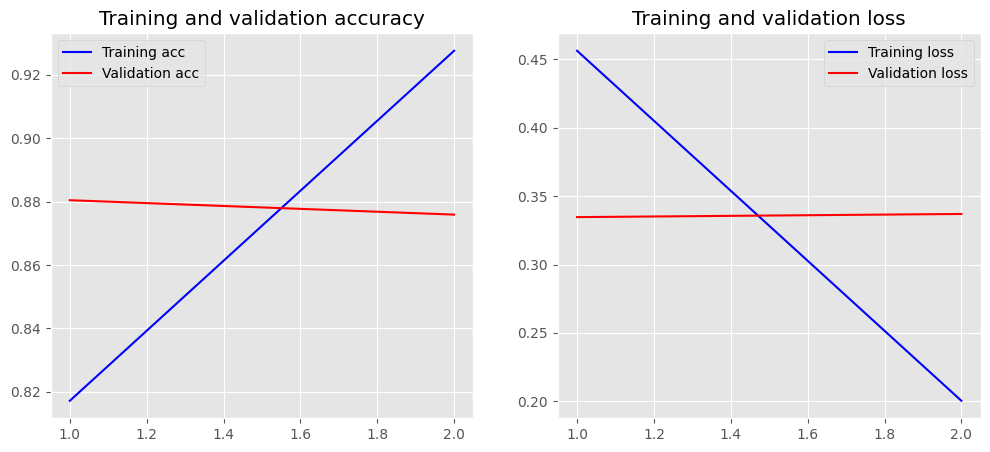

In [19]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
%matplotlib inline
plot_history(history)

## Testing chosen model

In [21]:
# Function for text cleansing
def text_cleansing(text):
    # lowercase
    clean_text = str(text).lower()
    # clean URL
    clean_text = re.sub(r'(http\S+|www\S+)', '', clean_text).strip()
    # clean emoticon byte
    clean_text = clean_text.replace("\\", " ")
    clean_text = re.sub(r'\bx[0-9a-fA-F]{2,}', ' ', clean_text)
    clean_text = re.sub(r'\bn\b', ' ', clean_text)
    clean_text = re.sub('\\+', ' ', clean_text)
    clean_text = re.sub('  +', ' ', clean_text)
    # clean punctuations
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', clean_text)
    # clean whitespace
    clean_text = ' '.join([j for j in clean_text.split()])
    return clean_text

In [25]:
from keras.models import load_model

input_text = """
aku sedih sekali.....
"""

def cleansing(sent):
    
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ", text[0])
print("Sentiment: ", sentiment[polarity])

1/1 [==============================] - 1s 666ms/step
Text:   aku sedih sekali      
Sentiment:  negative
